In [84]:
!pip install ipywidgets

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [85]:
! pip install graphviz

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [86]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta, binom
import itertools
from ipywidgets import interact, interactive
import pymc3 as pm

pm.__version__

'3.11.4'

# EDA

Research Questions:\
Hypothesis Testing 
1) Is the rate at which African Americans are shot different than would be expected given population proportions and does this change depending on armed status and on if the officer(s) had a body camera?

Bayesian Hierarchical Model\
2) What is the rate at which African Americans are shot assuming that police shootings of African Americans are under-reported?

In [87]:
# reads in current dataset from Washington Post github
data = pd.read_csv('https://raw.githubusercontent.com/washingtonpost/data-police-shootings/master/fatal-police-shootings-data.csv')
data.head()

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,longitude,latitude,is_geocoding_exact
0,3,Tim Elliot,2015-01-02,shot,gun,53.0,M,A,Shelton,WA,True,attack,Not fleeing,False,-123.122,47.247,True
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.0,M,W,Aloha,OR,False,attack,Not fleeing,False,-122.892,45.487,True
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.0,M,H,Wichita,KS,False,other,Not fleeing,False,-97.281,37.695,True
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.0,M,W,San Francisco,CA,True,attack,Not fleeing,False,-122.422,37.763,True
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.0,M,H,Evans,CO,False,attack,Not fleeing,False,-104.692,40.384,True


### Variable Visualization

In [88]:
counts_by_race = data[['race']].groupby('race').size()
counts_by_race

race
A     106
B    1557
H    1084
N      91
O      47
W    2970
dtype: int64

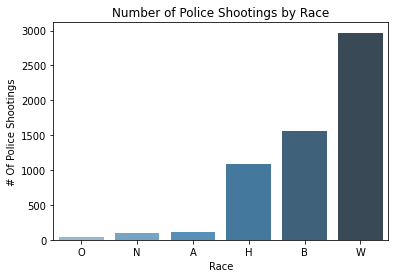

In [89]:
# O:'Other', N: 'Native American', A: 'Asian', H: 'Hispanic', B: 'Black, non-Hispanic', W: 'White, non-Hispanic'

sns.barplot(counts_by_race.index, 
            counts_by_race, 
            order=['O', 'N', 'A', 'H', 'B', 'W'], 
            palette = 'Blues_d')
plt.xlabel('Race')
plt.ylabel('# Of Police Shootings');
plt.title('Number of Police Shootings by Race');
plt.savefig('1.jpeg')

The ratio of Black deaths to White deaths is about 1/2. This is much different than their population proportions would suggest. We'll determine if this is significant using hypothesis testing.

In [90]:
# Drop null values
armed_race_data = data[['armed', 'race']].dropna()
# Get races used
races = list(armed_race_data['race'].unique())
# group by armed status and race
armed_race_data = armed_race_data.groupby(['race', 'armed']).size().sort_index(ascending=False).reset_index()
# change 'armed' column to 'armed' or 'unarmed'
armed_race_data['armed'] = ['unarmed' if x == 'unarmed' else 'armed' for x in armed_race_data['armed']]
# Rename column
armed_race_data = armed_race_data.rename(columns={0: 'count'})

armed_race_data.head(3)


,race,armed,count
0,W,armed,1
1,W,armed,3
2,W,armed,86


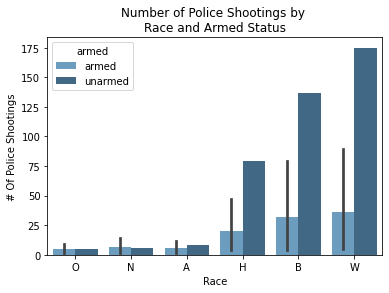

In [91]:
# O:'Other', N: 'Native American', A: 'Asian', H: 'Hispanic', B: 'Black, non-Hispanic', W: 'White, non-Hispanic'
sns.barplot(x='race', 
            y='count', 
            hue = 'armed',
            data = armed_race_data,
            order=['O', 'N', 'A', 'H', 'B', 'W'], 
            palette = 'Blues_d')
plt.xlabel('Race')
plt.ylabel('# Of Police Shootings');
plt.title('Number of Police Shootings by \nRace and Armed Status');
plt.savefig('2.jpeg')

Ratios between races are much closer for armed than unarmed. It will be interesting to determine if this is significant.

In [92]:
deaths_by_month = data[['date']]
deaths_by_month['date'] = [re.findall(r'\d{4}-\d{2}', x)[0] for x in deaths_by_month['date']]
deaths_by_month = deaths_by_month.groupby('date').size().to_frame().reset_index().rename(columns={0: 'deaths'})

deaths_by_month.head(3)


,date,deaths
0,2015-01,76
1,2015-02,77
2,2015-03,92


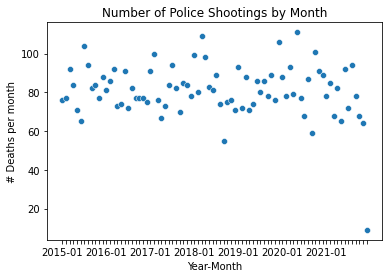

In [93]:
plot = sns.scatterplot(x='date', y='deaths', data=deaths_by_month);
[l.set_visible(False) for (i,l) in enumerate(plot.xaxis.get_ticklabels()) if i % 12 != 0]
plot.set_xlabel('Year-Month')
plot.set_ylabel('# Deaths per month');
plot.set_title('Number of Police Shootings by Month');
plot.figure.savefig('3.jpeg')

There doesn't appear to be a trend in deaths over time. This is relevant because it implies there is no effect associated with time that might be changing the rate of police shootings. This is important since we are using a dataset spread out over 6 years to make inferences about death rates now. We should also have a graphic giving deathrate over time by race—this will be done below. Since we are running our test over a large time frame a large time effect could impact our model. The only outlier is the month we're in almost certainly because it's not over yet.

In [94]:
def by_quarter(date):
    '''
    Splits months into quarters (not as crowded as months and more precision than years)
    date: a string in the form YYYY-MM-DD
    '''
    year = re.findall(r'\d{4}', date)[0]
    month = int(re.findall(r'\d{4}-(\d{2})', date)[0])
    if 1 <= month < 4:
        return year + '-' + 'Q1'
    if 4 <= month < 7:
        return year + '-' + 'Q2'
    if 7 <= month < 10:
        return year + '-' + 'Q3'
    if 10 <= month < 13:
        return year + '-' + 'Q4'

deaths_by_month = data[['date', 'race']]
deaths_by_month['date'] = [by_quarter(x) for x in deaths_by_month['date']]
deaths_by_month = deaths_by_month.groupby(['date', 'race']).size().to_frame().reset_index().rename(columns={0: 'deaths'}).reset_index()

deaths_by_month.head(3)

,index,date,race,deaths
0,0,2015-Q1,A,4
1,1,2015-Q1,B,64
2,2,2015-Q1,H,43


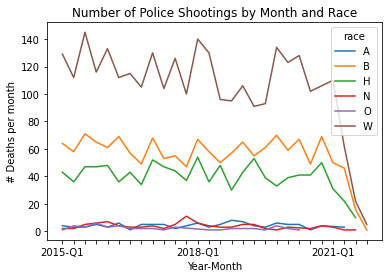

In [95]:
# O:'Other', N: 'Native American', A: 'Asian', H: 'Hispanic', B: 'Black, non-Hispanic', W: 'White, non-Hispanic'
plot = sns.lineplot(x='date', y='deaths', hue='race', data=deaths_by_month);
[l.set_visible(False) for (i,l) in enumerate(plot.xaxis.get_ticklabels()) if i % 12 != 0]
plot.set_xlabel('Year-Month')
plot.set_ylabel('# Deaths per month');
plot.set_title('Number of Police Shootings by Month and Race');
plot.figure.savefig('4.jpeg')

We can see that the trend in police shootings over time doesn't change between races. There is no apparent need to take time into account when making inferences about the rate of police shootings for a given race. This graph is relevant because we are using a dataset collected over 6 years to estimate a parameter (rate at which African Americans are shot) that might have changed over time. Since it seems to stay consistent we can continue without worrying. The sharp trend downward is not surprising. That last quarter is for 2021 October through December. Since we are only a little over half way through the quarter there are fewer decedents so this perceived sharp downward trend is of no concern.

### Data Cleaning and Preliminary Information

For Data Cleaning, we first removed all rows with missing armed or race values. Since we are investigating the roles race and armed status play in police shooting, we should deal very carefully with missing values. Interpolation would be a bad idea because we will very likely get wrong data from interpolation. The best thing to do here is to drop all rows with missig values. This is a tough decision because we have less than 7000 datapoints in our dataset and we have 326 rows with missing armed status and 882 rows with missing race information. We are removing a fair number of datapoints but this is nonetheless the best option. We have enough datapoints left to build a strong model and removing that many datapoints will not negatively impact our model performance and analysis in the end. In addition to dropping all rows with missing armed or race values, we removed age and date columns because our EDA above shows that these two columns do not have an effect on variables of interest to our research questions.

In [96]:
# Data set with only race
race_only = data[['race']].dropna().groupby('race').size().to_frame().rename(columns={0: 'decedents'})

# Data set with race and armed status
# Drop null values
race_armed = data[['armed', 'race']].dropna()
# change 'armed' column to 'armed' or 'unarmed'
race_armed['armed'] = ['unarmed' if x == 'unarmed' else 'armed' for x in race_armed['armed']]
# group by armed status and race
race_armed = race_armed.groupby(['race', 'armed']).size().sort_index(ascending=False).reset_index()
# Rename column
race_armed = race_armed.rename(columns={0: 'count'})

# Data set with race and camera
race_camera = data[['race', 'body_camera']].dropna()
race_camera = race_camera.groupby(['race', 'body_camera']).size().sort_index(ascending=False).reset_index()
race_camera = race_camera.rename(columns = {0: 'count', 'body_camera': 'camera'})

Observed proportion of shooting victims who are African American

In [97]:
total_shot = sum(race_only['decedents'])
print('Percentage African American: ' + str(race_only.loc[['B']]['decedents'][0] / total_shot))

Percentage African American: 0.2659265584970111


## Intro (The following is NOT part of EDA)

The ratio of African Americans shot about 0.266 of people who were shot by police. The ratio of African Americans out of the U.S. population is about $\frac{46936733}{331167284}=0.142$. Both values come from the U.S. Census Bureau; the number of African Americans comes from the figure shown below (the link to the pdf is below the figure) and the total number of people is the amount estimated by the U.S. Census Burea as of Jan 01 2020 (see [this](https://www.census.gov/popclock/) link).\
Notably our estimation of the proportion of Americans who are African Americans is higher than the Washington Post estimate. This is because they use the `Black alone` category rather than the `Alone or in Combination`. We use `Alone or in Combination` for reasons like the *'hypodescent laws'* which defined people as Black if they "had one drop of African blood." ([Stanford Encyclopedia of Philosophy](https://plato.stanford.edu/entries/race/)) Even if someone is not 100% African American it is still likely they face adversities due to systemic racism and so they may be subject to increased risk of police shootings.

![Population Proportions](redistricting_table.png)

**Figure 1** Above image is taken from the [U.S. Census Bureau](https://www2.census.gov/programs-surveys/decennial/2020/data/redistricting-supplementary-tables/redistricting-supplementary-table-01.pdf)



We have two goals: \
**1)** determine if there is a significant difference between the proportion of African Americans shot by police and the proportion of African Americans in the population (and whether or not this changes with armed status) \
**2)** Use a Bayesian model to approximate the true rate at which African Americans are shot by police under the assumptions that shooting of African Americans are more likely to not be reported (and not appear in the database) and that the Washington Post did not take into account that people who are not fully African American still struggle with systemic racism and so may have counted decedents who were not fully black as white.

## Multiple Hypothesis Testing

We are assuming each decedent is African American with probability  𝑝  similar to what this article on predicting race and police shootings does*. Since each decedent makes up a bernoulli random variable we—under the null hypothesis—model the number of African American decedents as  𝐵𝑖𝑛(𝑁,𝑝0)  where  𝑁  is the number of people shot and  𝑝0  is the proportion of the U.S. that is African American. We will use a overall significance level of 0.05 and Holm-Bonferroni procedure to adjust the significance level for each hypothesis test. The Holm-Bonferroni procedure also controls the strong familywise error rate like the Bonferroni adjustement but by ranking the p-values of the tests and adjusting the cutoff linearly we get higher power (this is a different algorithm from Benjamini-Hochberg though it sounds similar). We'll also use the Benjamini-Hochberg procedure since demonstrating that the racial distribution in police shootings under even just one conditions is still useful (i.e. while controlling for the false discovery rate if 5% of rejected tests are false discoveries only one is necessary to determine racial bias).

Assumptions
The main assumption we make is that each trial (i.e. each incident of a police shooting) is independent of the others. A moments reflection will reveal that this cannot be true since if a white person is killed they are no longer part of the population and the probability of a decedent being African American goes up under the null hypothesis. We can treat the trials as independent however since the removal of one white person from the population would increase the population proportion of African Americans by ~0.00000000043 percentage points (hardly enough to be significant). A related assumption is that each trial has the same probability of 'success'. Shootings aside, things like birth rate can also affect population proportions. The current proportion of African Americans in the U.S. is close to as high as it's ever been at 14.2%. Since this advantages our null hypothesis we know that birth rate and other forms of demographic drift will not increase the chance of a type 1 error beyond what we control for.

* The authors are looking for the probability of being shot while African American rather than the probability that a decedent was African American. The assumptions are similar.

**Hypothesis Testing Question 1**: Is the rate at which African Americans are shot different than would be expected given population proportions?

$H_0$: The probability a decedent is African Americans does not differ from the given population proportion.\
$H_1$: The the probability a decedent is African Americans does differ from the given population proportion.

Distribution of African American decedents under the null hypothesis: $Bin(N, p_0) \implies Bin(5855, 0.142)$ where $N$ is the number of people shot by police and $p_0$ is the proportion of the U.S. population that is African American. The observed number of decedents who are African American is 1557 (26.6%). The p-value—the probability of getting the observed number of African American decedents or more under the null hypothesis—is

$$\sum_{k = 1557}^{5855} {5855 \choose k} p_0^k (1-p_0)^{5855 - k}$$

In [98]:
p_race_only = 1-binom.cdf(1557, 5855, 0.142)
p_race_only

0.0

**Hypothesis Testing Question 2:** Is the rate at which African Americans are shot different than would be expected given population proportions depending on armed status?\
We will perform two tests; one test will be on armed individuals and the other will be on unarmed individuals.

**Armed**\
$H_0$: The probability an armed decedent is African Americans does not differ from the given population proportion.\
$H_1$: The the probability an armed decedent is African Americans does differ from the given population proportion. 

Number of armed decedents: 5248\
Number of Black decedents: 1364

$$\text{p-value} = \sum_{k = 1364}^{5248} {5248 \choose k} p_0^k (1-p_0)^{5248 - k}$$

In [99]:
p_armed = 1-binom.cdf(1364, 5284, 0.142)
p_armed

0.0

**Unarmed**\
$H_0$: The probability an unarmed decedent is African Americans does not differ from the given population proportion.\
$H_1$: The the probability an unarmed decedent is African Americans does differ from the given population proportion. 

Number of unarmed decedents: 410\
Number of Black decedents: 137

$$\text{p-value} = \sum_{k = 137}^{410} {410 \choose k} p_0^k (1-p_0)^{410 - k}$$

In [100]:
p_unarmed = 1-binom.cdf(137, 410, 0.142)
p_unarmed

0.0

**Hypothesis Testing Question 3:** Is the rate at which African Americans are shot different than would be expected given population proportions depending on if the officer was wearing a body camera?\
We will perform two tests; one test will be on individuals shot by police without body cameras and the other on individuals shot by police with body cameras.

**No Camera**\
$H_0$: The probability a decedent is African Americans does not differ from the given population proportion when the officer wasn't wearing a body camera.\
$H_1$: The the probability a decedent is African Americans does differ from the given population proportion when the officer wasn't wearing a body camera. 

Number of decedents: 5032\
Number of Black decedents: 1258

$$\text{p-value} = \sum_{k = 1258}^{5032} {5032 \choose k} p_0^k (1-p_0)^{5032 - k}$$

In [101]:
p_NoCamera = 1-binom.cdf(1258, 5032, 0.142)
p_NoCamera

0.0

**Camera**\
$H_0$: The probability a decedent is African Americans does not differ from the given population proportion when the officer was wearing a body camera.\
$H_1$: The the probability a decedent is African Americans does differ from the given population proportion when the officer was wearing a body camera. 

Number of decedents: 832\
Number of Black decedents: 299
$$\text{p-value} = \sum_{k = 299}^{832} {832 \choose k} p_0^k (1-p_0)^{832 - k}$$

In [102]:
p_Camera = 1-binom.cdf(299, 832, 0.142)
p_Camera

0.0

Holm-Bonferroni Procedure:

For ordered (lowest to highest) p-values $P_1, P_2,...,P_m$ where $P_k$ is the k<sup>th</sup> p-value we can adjust the significance level cutoff $\alpha$ for each p-value and control the strong familywise error rate using the following method. If $P_k < \frac{\alpha}{m+1-k}$

In [103]:
p_val_list = np.sort([p_race_only, p_armed, p_unarmed, p_NoCamera, p_Camera])
p_val_list

array([0., 0., 0., 0., 0.])

The lowest cutoff is $\frac{0.05}{5} = 0.01$. Our highest p-value is 0. We will reject all null hypotheses and conclude that the probability a decedent is African American does not follow the population proportion regardles of armed status or whether or not the officer(s) were wearing a body camera.

Benjamini-Hochberg Procedure:

In [104]:
# rank * alpha / M
values = np.array([i * 0.05 / 5 for i in range(1,6)])
for i in np.arange(4,-1,-1):
    if p_val_list[i] < values[i]:
        cutoff = p_val_list[i]
cutoff

0.0

Unsurprisingly our cutoff is zero. Since we compare each value to see if it's less than *or equal* we reject each test again.

In conclusion, the proportion of decedents who are African American does not follow population proportions.

## Bayesian Modeling

$P(\theta | X_1,X_2,...,X_n) \propto P(X_1,X_2,...,X_n | \theta)P(\theta)$ \
$X_i$ a bernoulli random variable indicating whether or not decedent *i* was African American with probability $\theta$. The likelihood $P(X_1,X_2,...,X_n | \theta)$ is a binomial distribution and $P(\theta)$ is a beta distribution with a mean greater than 0.266. We chose a mean of 1/3 with beta distribution shape parameters $\alpha = 3$ and $\beta = 6$. We kept the size of $\alpha$ and $\beta$ low since we do not have high confidence in our prior.

### 1. Data Processing

Prepare the data by one-hot encoding all categorical variables. Also, impute the NaN values of age as average of whole population.

In [105]:
# drop the undefined races
data = data.dropna(subset = ['race'])

# select features
Xf = data[['armed','age','gender','signs_of_mental_illness', 'threat_level', 'flee', 'body_camera']]
Xf['is_black'] = data['race'] == 'B'

# One hot encoding features
Xf = pd.get_dummies(Xf,dummy_na=True,drop_first=True)

# impute missing features
Xf.loc[Xf['age'].isna(),'age'] = Xf['age'].mean()

### 2. Pooled Bayesian Modeling

First consider simple pooled model:
$$X|\theta \sim Bernoulli(\theta)$$

With prior $\theta \sim Beta(3,6)$  Simulate for 1000 times.

In [106]:
def pooled_inference(alpha, beta, study_df):
    """
    Creates and fits a PyMC3 model corresponding to the graphical model above
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        Outputs: (model, trace)
    """
    with pm.Model() as model:
        theta = pm.Beta('theta', alpha=alpha, beta=beta)
        X = pm.Bernoulli('is_black', p=theta, observed=study_df['is_black'])
        trace = pm.sample(1000, tune=1000, target_accept=0.95)
    return (model, trace)

# assume the true theta is around beta(1,2) with mean of 0.33> 0.266
mdl, trace = pooled_inference(3, 6, Xf)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 6 seconds.


The result shows 95% credible interval is [0.255,0.277] which covers the empirical result 0.266. There is no indication that police shootings of African American is  under-reported.

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Estimated theta 0.266
95% BCI: [0.255, 0.277]


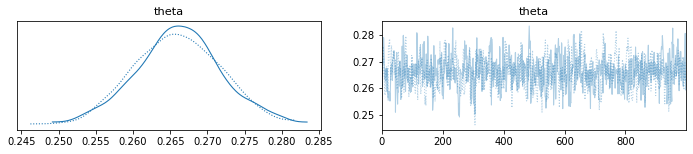

In [107]:
# Trace plot
pm.traceplot(trace)

# report mean and credible interval
mean = np.mean(trace['theta'])
low = np.percentile(trace['theta'], 2.5)
high = np.percentile(trace['theta'], 97.5)

print(f"Estimated theta {mean:.3f}")
print(f"95% BCI: [{low:.3f}, {high:.3f}]")

### 3. Hierarchical Model With Body Camera Variable
Assumption:

The presence of body camera should be independent to the case because it happens randomly. However, cases without body camera record are not likely to be reported. Because without body camera, police can decline the shooting and reported to other incidence without evidence.

EDA

Here is the rate of body camera vs race. The rate of African-American deadly shootings have higher camera presence rate, especially compare to white. We will include the presence of a camera as a variable to determine if this changes the estimated proportion of African American decedents.

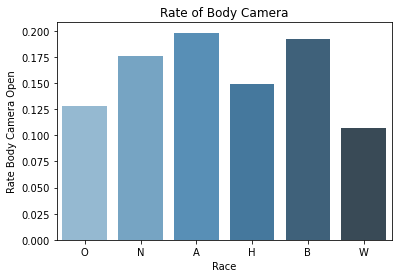

In [108]:
counts_by_race = data.groupby(['race'])['body_camera'].mean()

sns.barplot(counts_by_race.index, 
            counts_by_race, 
            order=['O', 'N', 'A', 'H', 'B', 'W'], 
            palette = 'Blues_d')
plt.xlabel('Race')
plt.ylabel('Rate Body Camera Open');
plt.title('Rate of Body Camera');

Build the Bayesian model: $X_i | \theta, \beta \sim Bern(\pi)$, where $\pi = \theta e^{-\beta z_i}$, where $z_i \in \{0,1\}$ indicates whether the body camera record is MISSING or not (1 is missing).

The prior of θ keeps the same: θ∼Beta(3,6). Since we assume β>0, take the prior β=Unif[0,1].

In [109]:
def hierarchical_inference(alpha, beta, study_df):
    """
    Creates and fits a PyMC3 model corresponding to the graphical model above
    Inputs:
        alpha_value, beta_value : floats, parameters of the prior Beta Distribution
        study_df : DataFrame containing study data
        Outputs: (model, trace)
    """
    with pm.Model() as model:
        body_camera = pm.Data("no_camera", 1-study_df["body_camera"])
        theta = pm.Beta('theta', alpha=alpha, beta=beta)
        beta = pm.Uniform('beta')
        X = pm.Bernoulli('is_black', p=theta * np.exp(-beta*body_camera), observed=study_df['is_black'])
        trace = pm.sample(1000, tune=1000, target_accept=0.95)
    return (model, trace)

# assume the true thea is around beta(1,2) with mean of 0.33> 0.266
mdl, trace = hierarchical_inference(3, 6, Xf)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


The visualiation of model is shown below. The observed variable is whether the case has body camera record.

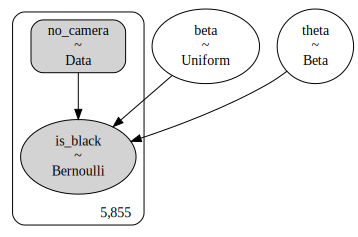

In [110]:
pm.model_to_graphviz(mdl)

The result shows 95% credible interval is [0.333, 0.394] which is significantly different thant the empirical result 0.266. This is leads the result that the police short of African American is indeed unde-reported.

This also gives the estimated probability of under report if no camera present: P=1−exp⁡(1−β)P =1- \exp(1-\beta)P=1−exp(1−β) The 95% credible interval is [0.232,0.374][0.232,0.374][0.232,0.374]. On average, 30.8% of the cases without body camera record will be under reported.

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.
Estimated theta 0.362
95% BCI: [0.330, 0.396]
Estimated probability of under-report if no camera present 0.309
95% BCI: [0.372, 0.241]


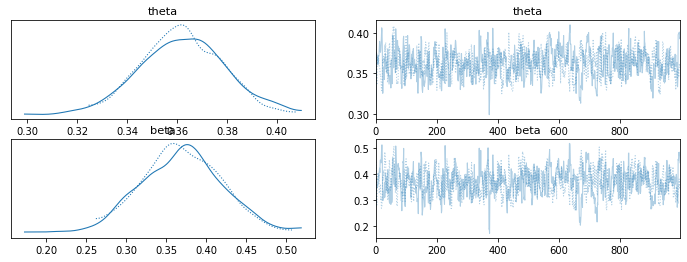

In [111]:
# Trace plot
pm.traceplot(trace)

# report mean and credible interval
mean = np.mean(trace['theta'])
low = np.percentile(trace['theta'], 2.5)
high = np.percentile(trace['theta'], 97.5)

print(f"Estimated theta {mean:.3f}")
print(f"95% BCI: [{low:.3f}, {high:.3f}]")

# report mean and credible interval
mean = 1- np.exp(-np.mean(trace['beta']))
high = 1- np.exp(- np.percentile(trace['beta'], 2.5))
low =1-np.exp(-np.percentile(trace['beta'], 97.5))

print(f"Estimated probability of under-report if no camera present {mean:.3f}")
print(f"95% BCI: [{low:.3f}, {high:.3f}]")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=32e079f4-7538-411f-902e-8233a612d242' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>